In [15]:
#python-r imports 
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
%reload_ext rpy2.ipython

#common imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
%matplotlib inline

#importing r objects
ts = robjects.r('ts')
bsts = importr('bsts')

#activating automated pandas conversion to and from r objects
pandas2ri.activate()

In [2]:
#loading AirPassenger timeseries data
ap = pd.read_csv('/Users/pranav.bahl/Documents/AirPassengers.csv',index_col=0,infer_datetime_format=True)

#Adding time index to the dataframe
ap.index = pd.date_range('1949-01-01','1960-12-31',freq='M')

#Taking log of base 10 on data to dampen the amplification
ap = np.log10(ap)

#train data is an year lesser data than actual
train_data = ap[:-12]

#test data is last year time series for model testing
test_data = ap[-12:]

#converting AirPasenger data to r timeseries, if you try passing the data without converting it to native R time series
#then it will throw an error
r_train_data = ts(train_data.AirPassengers.values,frequency=12)
r_test_data = ts(test_data.AirPassengers.values,frequency=12)

/Users/pranav.bahl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=52,center=False).mean()
  if __name__ == '__main__':
/Users/pranav.bahl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=52,center=False).std()
  from ipykernel import kernelapp as app


(array([ 711858.,  712223.,  712588.,  712954.,  713319.,  713684.,
         714049.,  714415.,  714780.,  715145.]),
 <a list of 10 Text xticklabel objects>)

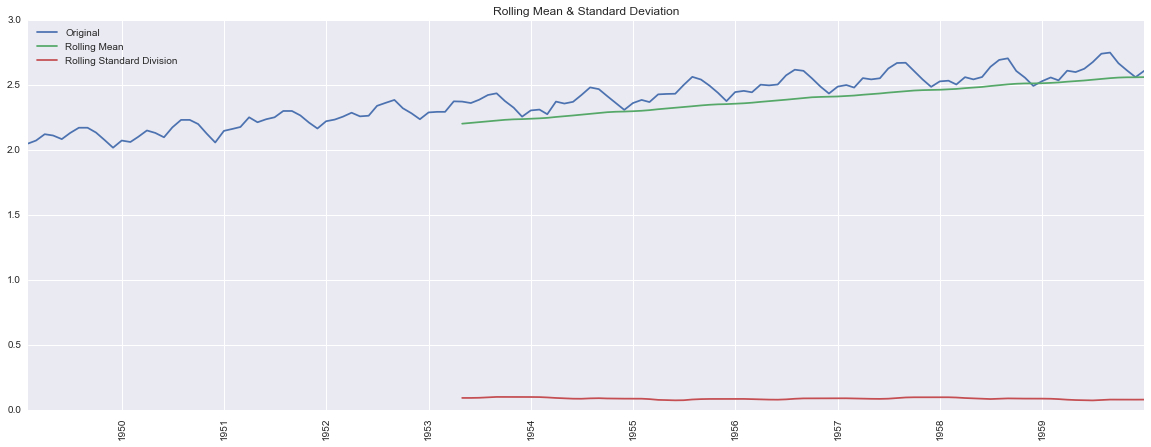

In [13]:
rollingmean = pd.rolling_mean(train_data,window=52)
rolstd = pd.rolling_std(train_data,window=52)

plt.figure(figsize=(20,7))
plt.plot(train_data,label='Original')
plt.plot(rollingmean,label='Rolling Mean')
plt.plot(rolstd,label='Rolling Standard Division')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.xticks(rotation='90')

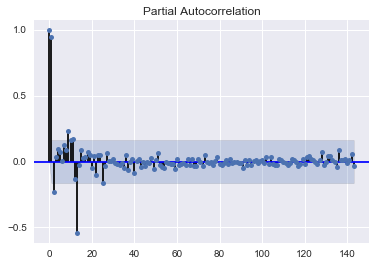

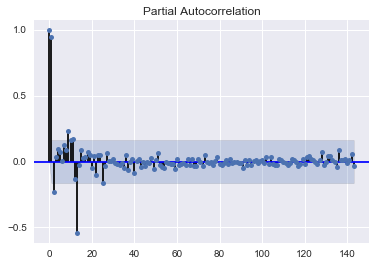

In [16]:
#plotting Partial Autocorrelation of data to extract information about Auto Regression lags
plot_pacf(ap)

In [3]:
#adding Trend and Seasonality information to state specification
ss = bsts.AddLocalLinearTrend(list(),r_train_data)
ss = bsts.AddSeasonal(ss,r_train_data,nseasons=12)

#One of the reason to pick BSTS over ARIMA is you can even add AR(Auto Regression) to state specification making model
#more stronger
ss = bsts.AddAr(ss,r_train_data,lags=2)

#building BSTS model
#ss -- state specification to be passed for modeling
#niter -- Specifies the number of MCMC draws
#ping -- if the value for this variable is greater than 0 it shows MCMC draws details 
bsts_model = bsts.bsts(r_train_data,ss,niter=500,ping=0)

#computing burn to avoid initial iterations of model with low confidence
burn = pandas2ri.ri2py(bsts.SuggestBurn(0.1,bsts_model))

#making prediction for year 1960
prediction = bsts.predict_bsts(bsts_model,horizon=12,burn=burn)

prediction_distribution = pd.Series(prediction[3])

#Extracting predictions
prediction_values = pd.Series(prediction[1],index=test_data.index)
prediction_values = 10**prediction_values

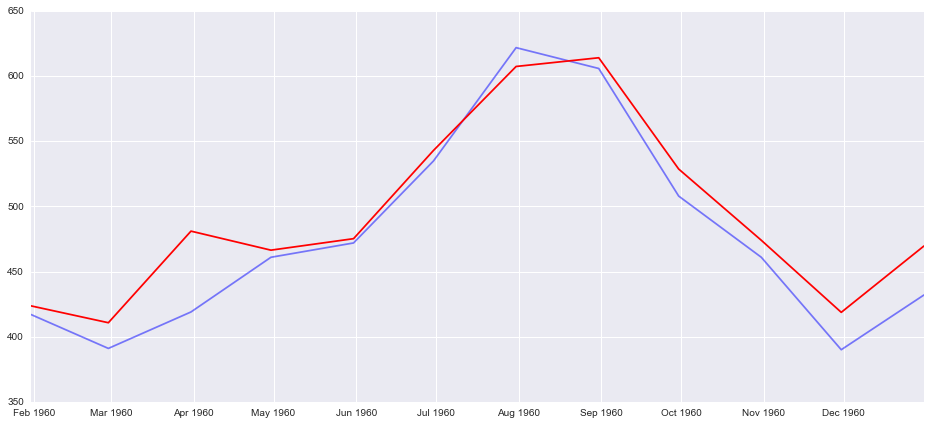

In [4]:
#Plotting the prediction against ground truth
fig = plt.figure(figsize=(16,7))
ax=plt.axes()
ax.plot(test_data.index,10**test_data.AirPassengers.values,color='blue',alpha=0.5)
ax.plot(prediction_values,color='red')

In [7]:
#Computing model's fitted values across the distribution
prediction_error = pandas2ri.ri2py_dataframe(bsts.bsts_prediction_errors(bsts_model))
prediction_error = prediction_error.ix[int(burn):]
prediction_error = prediction_error.mean(axis=0)
prediction_error.index = train_data.index
fitted_value = prediction_error.add(train_data.AirPassengers)
fitted_value = 10**fitted_value
fitted_value = fitted_value.append(10**prediction_values)
fitted_value.names = ['time','Fitted']

In [8]:
#Embedding the actual values for comparison
ap = 10**ap
fitted_actual = pd.concat([fitted_value,ap],axis=1)
fitted_actual.columns = ['Fitted','Actual']

In [9]:
#Extracting 95% quantile value
interval = pandas2ri.ri2py(prediction[2])
posterior_interval = pd.DataFrame(pandas2ri.ri2py(prediction[2]).T)
posterior_interval.columns = ['LL','UL']
posterior_interval.index = test_data.index
fitted_actual = fitted_actual.join(10**posterior_interval)

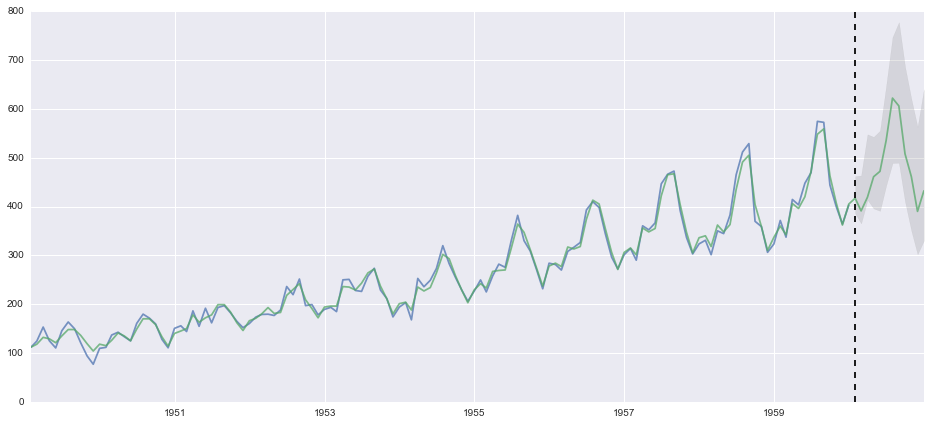

In [11]:
#Plotting 95% quantile
fig = plt.figure(figsize=(16,7))
ax=plt.axes()
ax.plot(fitted_actual['Fitted'],alpha=0.75)
ax.plot(fitted_actual['Actual'],alpha=0.75)
ax.fill_between(fitted_actual.index,fitted_actual['LL'],fitted_actual['UL'],alpha=0.20,color='grey')
ax.axvline(x=test_data.index[0], color='k', linestyle='--')

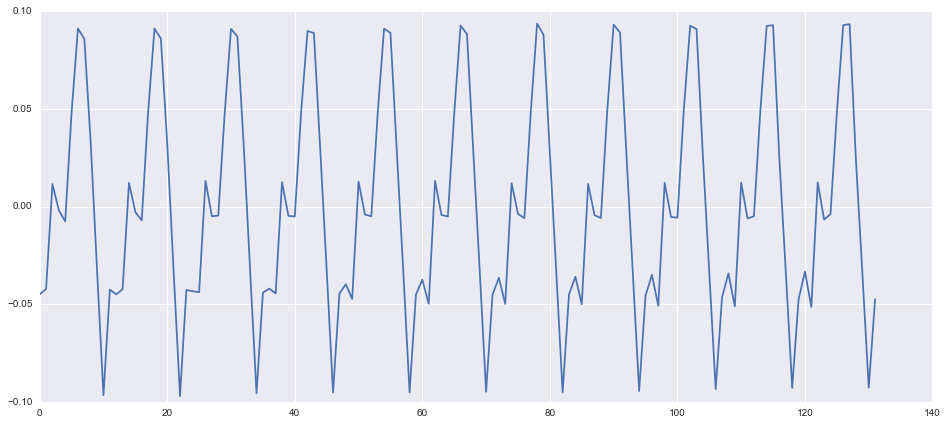

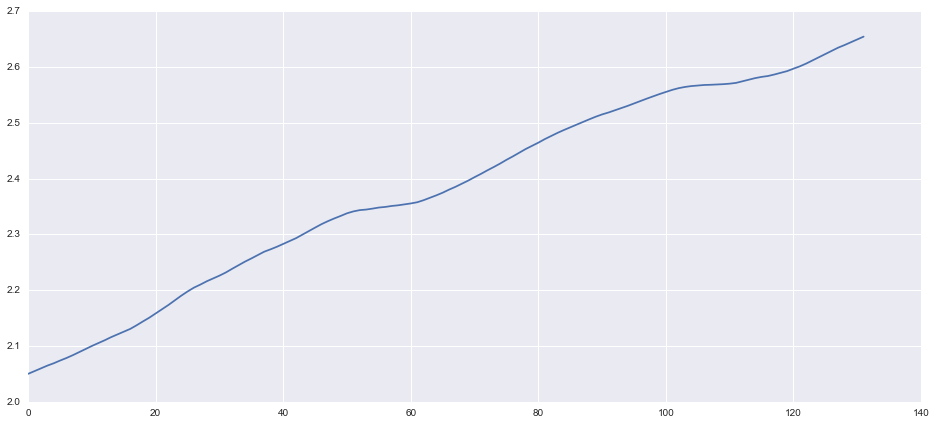

In [12]:
#%R is magic function for R, used to extract the trend and seasonality information about AirPassenger data
%R -i burn,bsts_model -o trend trend = colMeans(bsts_model$state.contributions[-(1:burn),1,])
%R -i burn,bsts_model -o seasonality seasonality = colMeans(bsts_model$state.contributions[-(1:burn),2,])


#Plotting model's seasonality and trend
fig = plt.figure(figsize=(16,7))
ax=plt.axes()
ax.plot(seasonality)
fig = plt.figure(figsize=(16,7))
ax=plt.axes()
ax.plot(trend)